In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [3]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [4]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

In [49]:
data.columns.values

array(['ref_id', 'zb', 'odds', 'pz_width', 'zb_mean', 'chi2', 'n_band',
       'ebv', 'qz', 'best_run', 'production_id', 'paudm_id', 'ra', 'dec',
       'zp_gal', 'zl68_gal', 'zu68_gal', 'zl99_gal', 'zu99_gal', 'zp_sec',
       'dchi', 'imag', 'ei', 'i_auto', 'nbfilt', 'mod_gal', 'type',
       'umag', 'bmag', 'vmag', 'gmag', 'rmag', 'zmag', 'icmag', 'jmag',
       'kmag', 'mv', 'ebv_gal', 'ebv_int', 'acs_a_image', 'acs_b_image',
       'acs_theta_image', 'acs_mag_auto', 'acs_magerr_auto', 'zspec',
       'conf', 'f814w', 'zfits', 'r50', 'sersic_n_gim2d', '_col50',
       '_col54', 'n_coadd', 'run', '_col57', 'band0', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15',
       'band16', 'band17', 'band18', 'band19', 'band20', 'band21',
       'band22', 'band23', 'band24', 'band25', 'band26', 'band27',
       'band28', 'band29', 'band30', 'band31', 'band32', 'band33',
       'band34', '

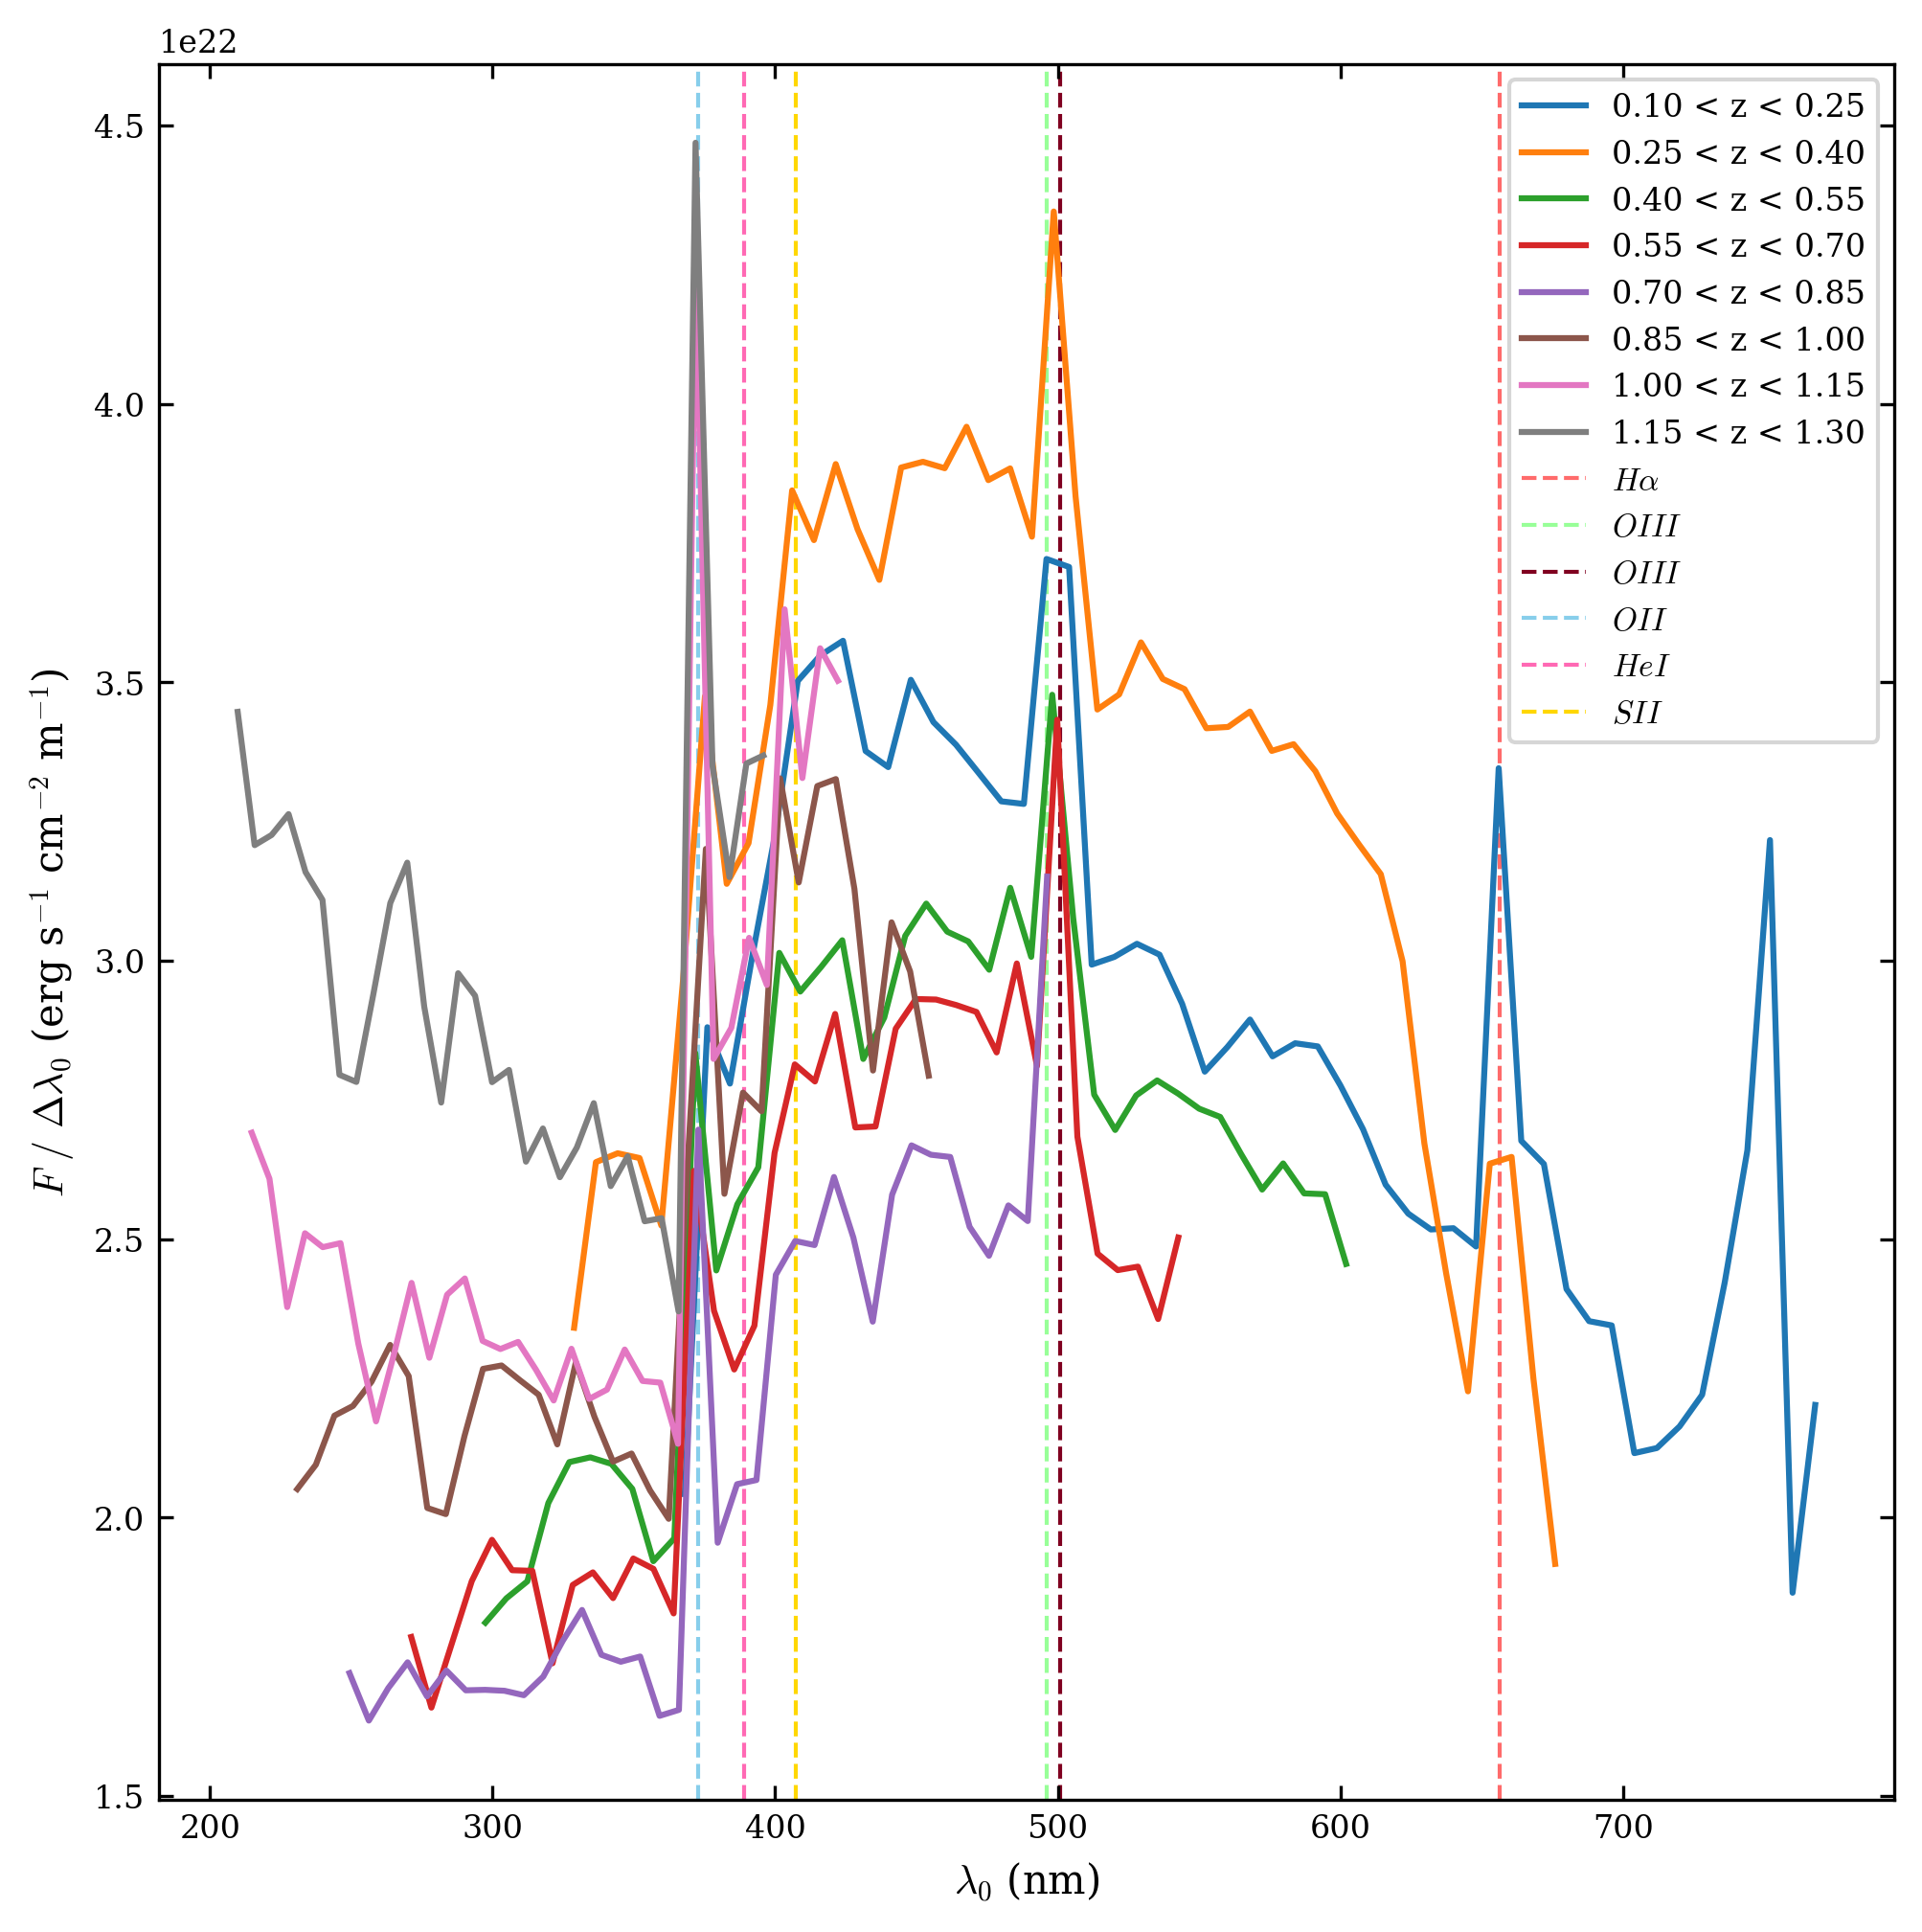

In [12]:
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']




################################# PLOT 1 #################################



# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

factor = 1/8.5 * latex_textwidth/72

fig = plt.figure(figsize=(8,8),dpi=300)
# ax1 = plt.subplot(121)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(data_sample.loc[:,'band0':'band39'])

increments = np.linspace(90,150,len(bins))

all_means = []
# bandwidtharray = np.linspace(7.4,4.5,len(bins))
bandwidtharray = np.linspace(8,6,len(bins))


for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
#     print(z_samp)
#     print(z_samp.size,flux_sample.size,z_photos.size)
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    #Pre- broken
#     binned_means = [np.nanmedian(flux_sample[digitized == i]) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

    FWHM = 13
    cgs_factor = 10**(-(26+48.6)/2.5)
    
#     binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    # ^ what has been used so far
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]*3e8/(lamb_sample[digitized==i]*10**-9)**2) for i in range(1,len(band_bins))]
    # ^bogus???
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}".format(z_bin[0],z_bin[1]),zorder=10,linewidth=1.5) #flux(in AB mags)/500 band wl
    

                                 
        

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['#ff6b6b','#98ff98','#800020','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],color=colours[i],linestyle='--',zorder=1,label=line[1])

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F\ /\ \Delta\lambda_0$ (erg s$^{-1}$ cm$^{-2}$ m$^{-1}$)')
# plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
fixed_aspect_ratio(1)
# custom_SAVEFIG(filetag='SED_LD')

# plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
# plt.show()



# fig.subplots_adjust(wspace=0.25)
# fig.subplots_adjust(bottom=0.3)
# ax1.yaxis.labelpad, ax2.yaxis.labelpad = 1,1

plt.legend()
# custom_SAVEFIG(filetag='SED_LD')
plt.show()



/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


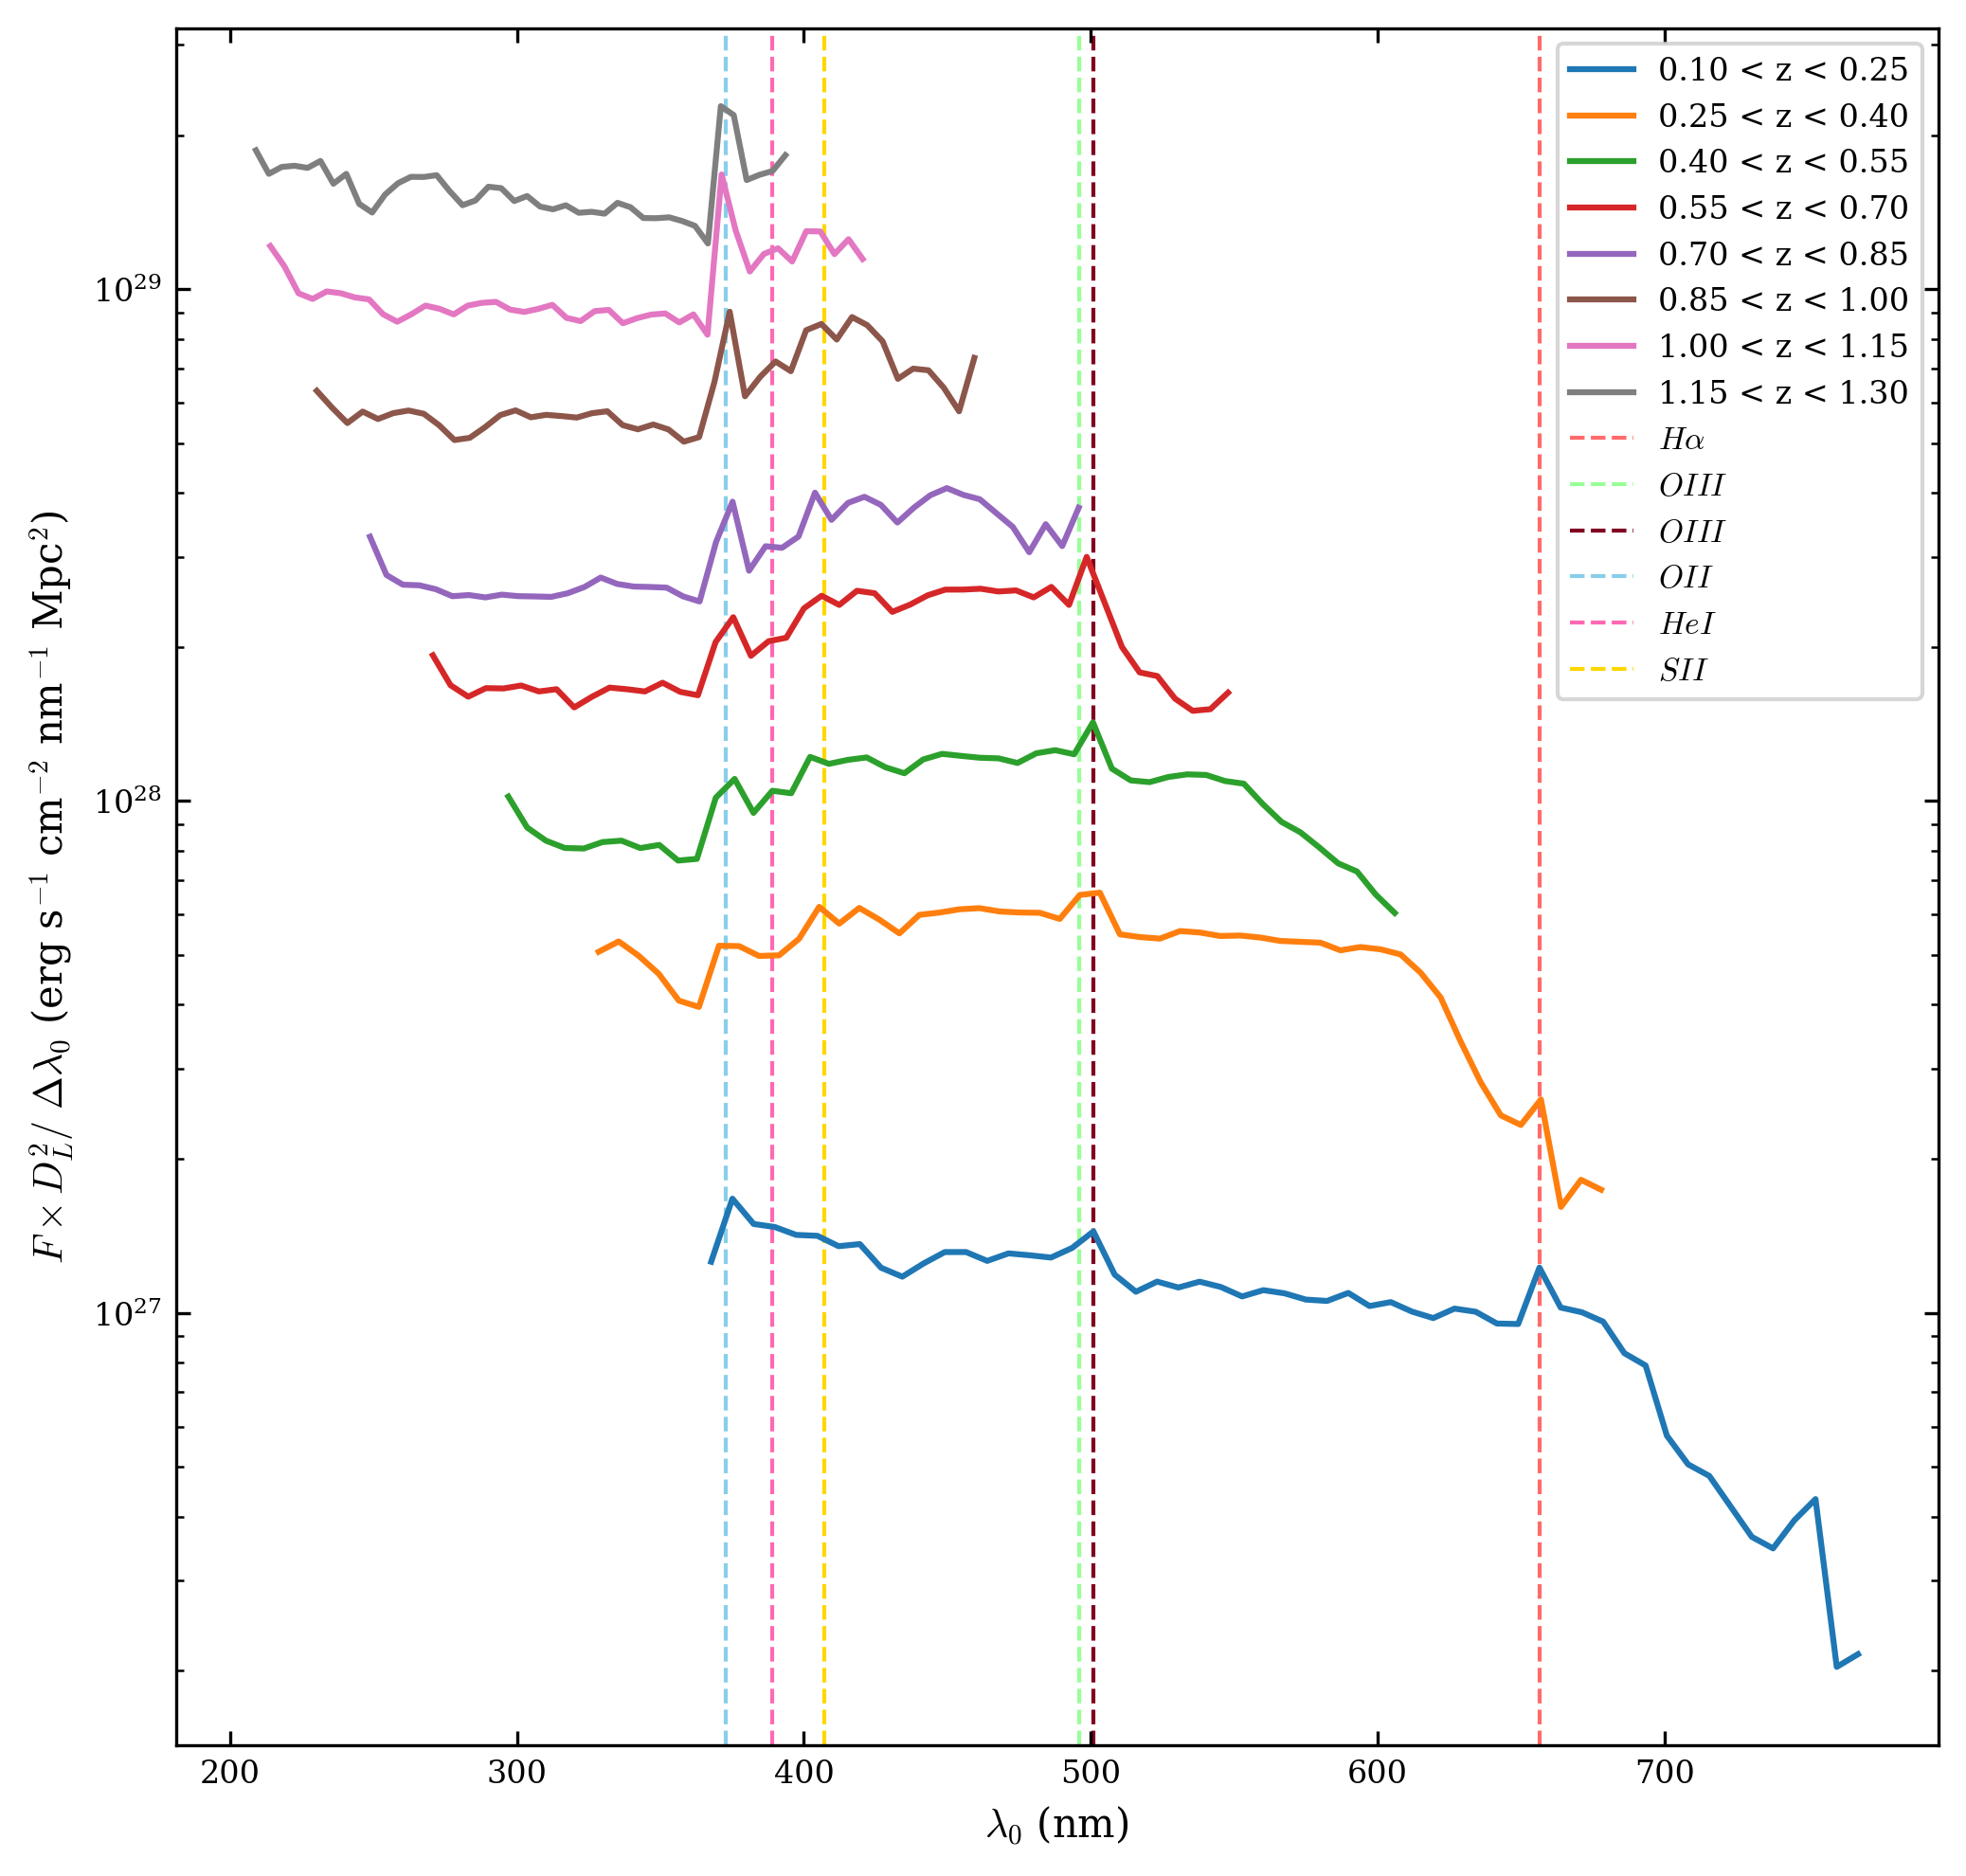

In [7]:


################################# PLOT 2 #################################
fig = plt.figure(figsize=(8,8),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
max_factor = 7.25
# factor = 1/max_factor*latex_textwidth/72
# fig = plt.figure(figsize=(7.5*factor,max_factor*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())

increments = np.linspace(90,150,len(bins))

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])
# band_bins = np.arange(200,860,band_bin_incs[ind])

for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))
#     print(band_bins)
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
# Pre-changed
#     binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
# #     print (binned_means)
    
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl
    
    FWHM = 13 #nm
    cgs_factor = 10**(-(26+48.6)/2.5)
    
#     binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])*lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])*lum_dist_sample[digitized == i]**2*3e8/(lamb_sample[digitized==i]*10**-9)**2) for i in range(1,len(band_bins))]
    
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}".format(z_bin[0],z_bin[1]),zorder=10,linewidth=1.5) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]

for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F \times D_L^2 /\ \Delta\lambda_{0}$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$ Mpc$^2$)')
plt.legend()

# ax1.tick_params(labelbottom=False)

plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
fixed_aspect_ratio(1)

plt.show()

In [8]:
print(cgs_factor)

1.4454397707459398e-30


In [18]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

In [45]:
r1, g1, b1 = 255, 235, 247
r1, g1, b1 = r1/255, g1/255, b1/255

cdict1 = {'red':   ((0.0, r1, r1),
                   (1.0, 0.75, 0.75)),

         'green': ((0.0, g1, g1),
                   (1.0, 0.04, 0.04)),

         'blue':  ((0.0, b1, b1),
                   (1.0, 0.4, 0.4)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 1.0, 1.0),
                    (1.0, 1.0, 1.0))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearPurple', cdict1)
plt.register_cmap(cmap=clear_purple)

# kNN

In [42]:
ML_DATA = pd.read_csv('../../ML runs/SPEC_advanced5/ANNZ_randomReg_0000.csv',header=0)
N_points = 500
indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zspec']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 1.12e-02 
st. dev of normed error                       = 0.085
Percentage of 'catastrophic' outliers         = 7.258%
half width of 68th percentile of normed error = 0.060


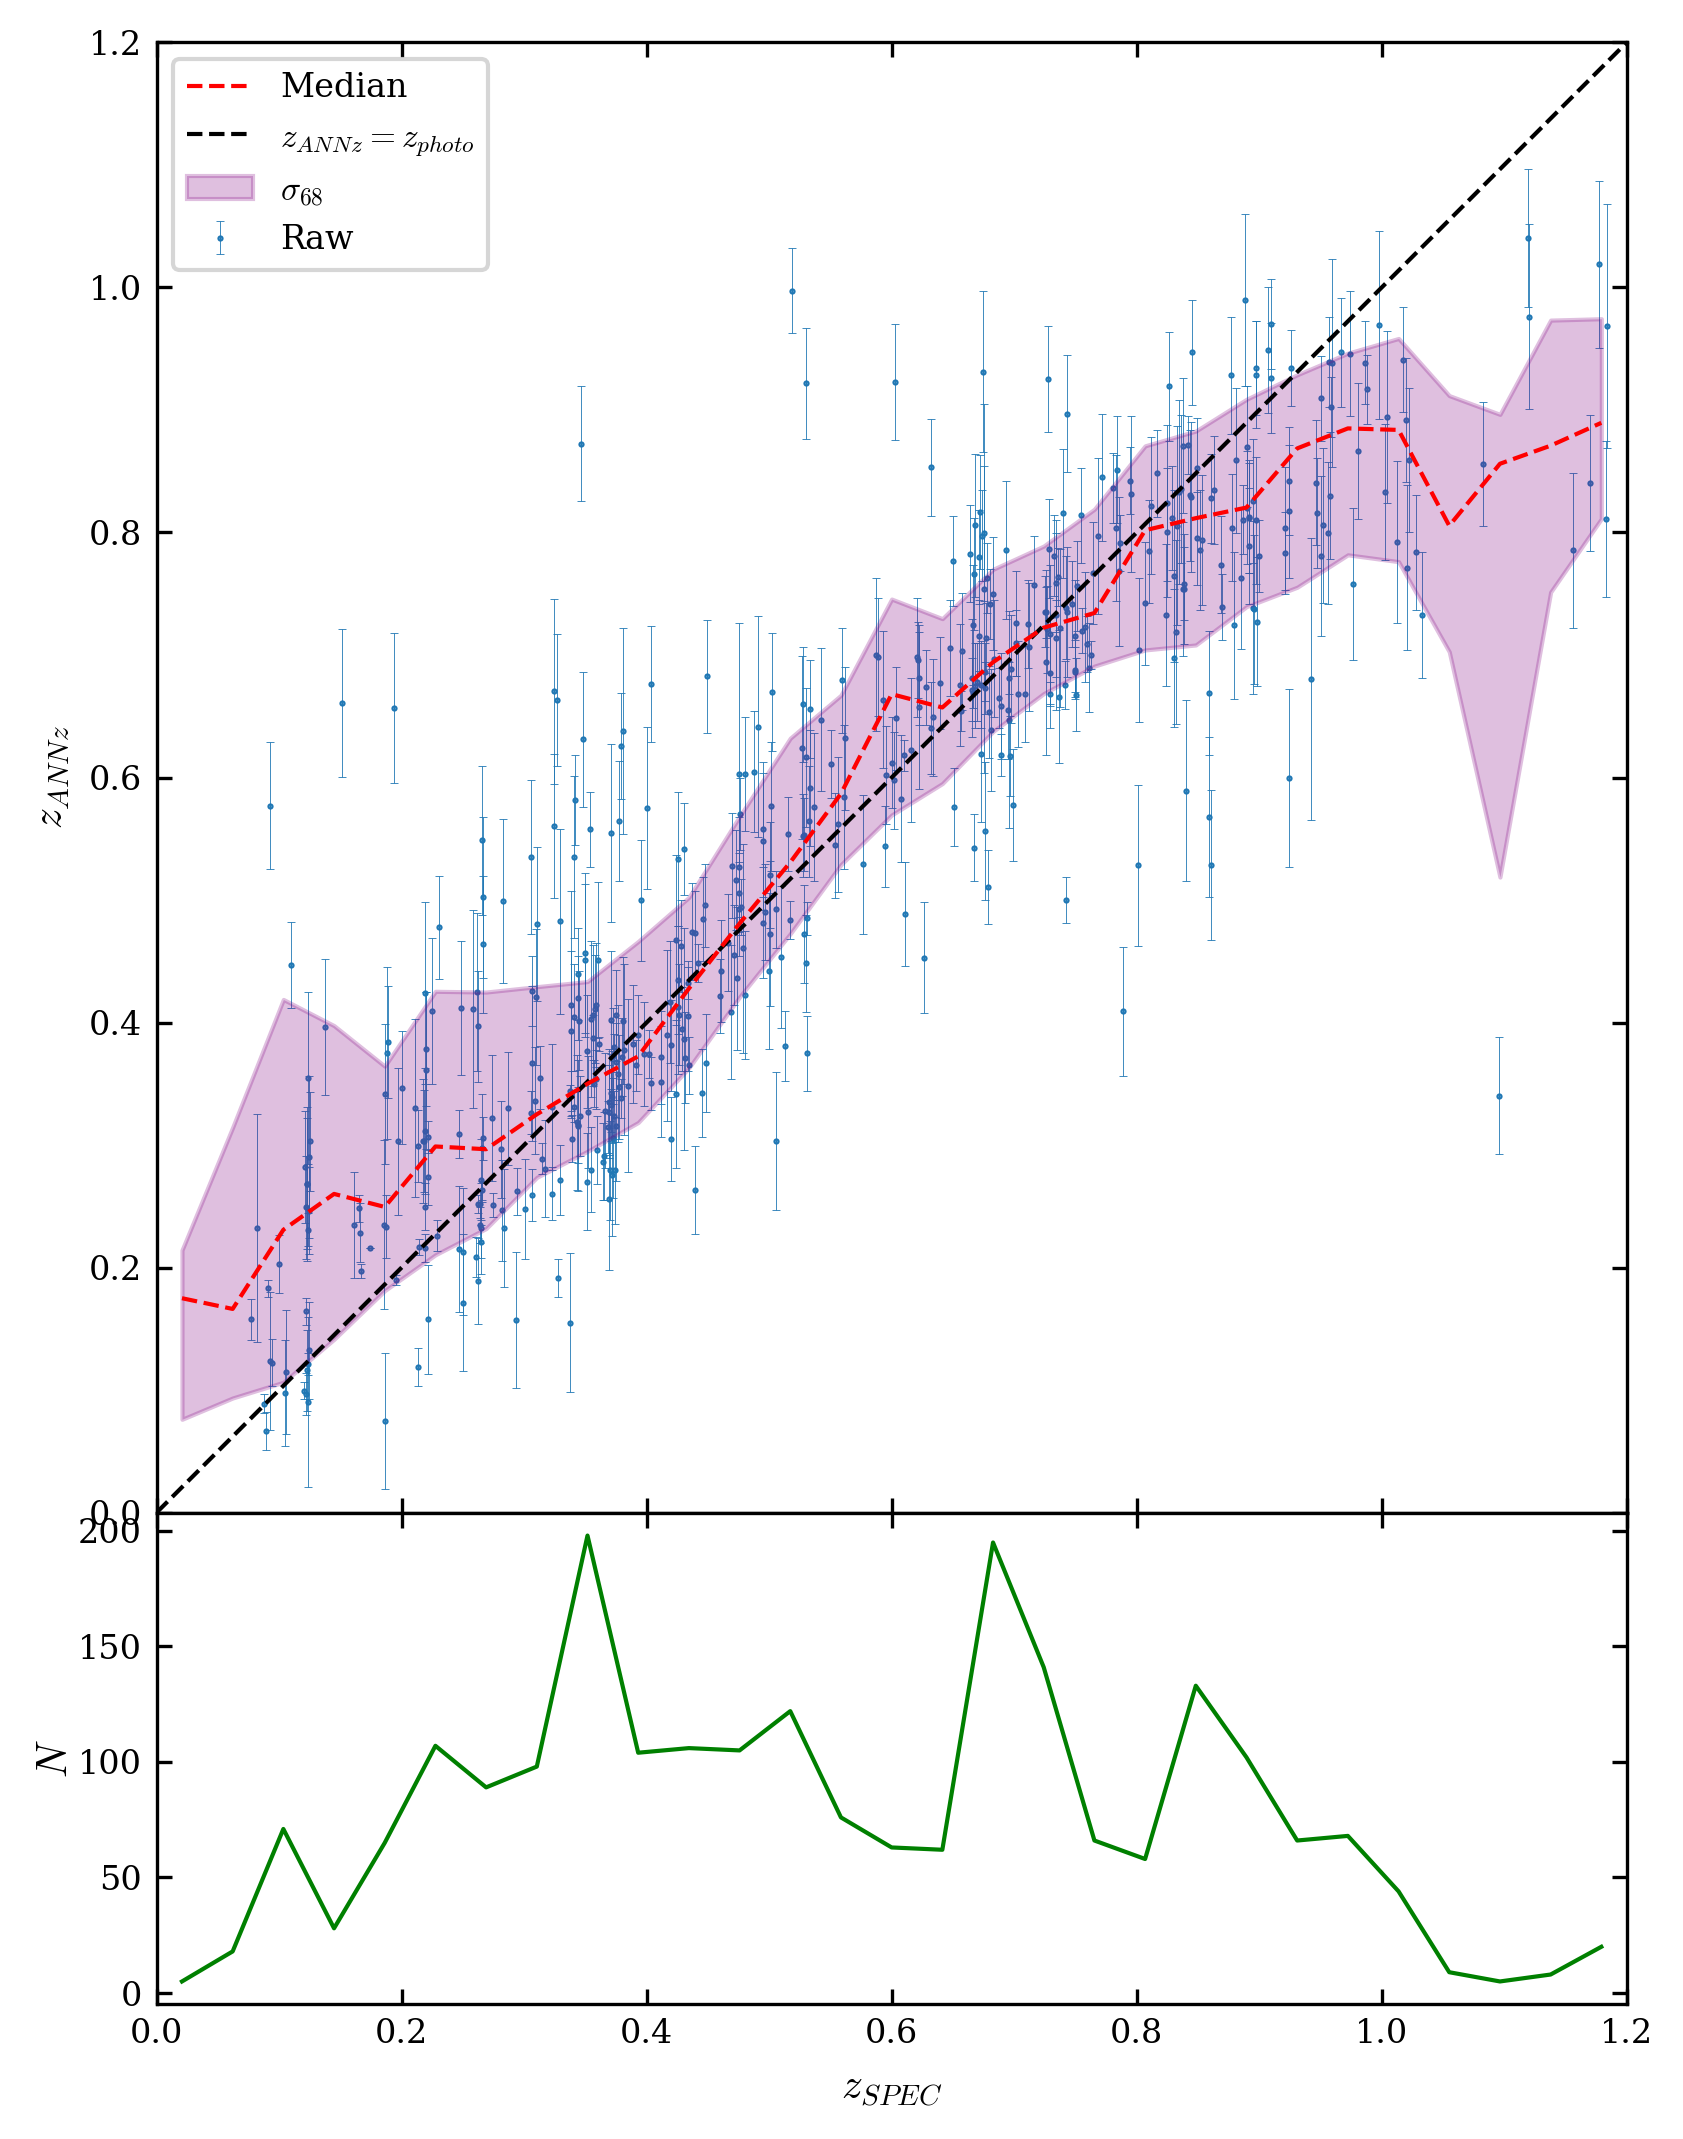

In [43]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{SPEC}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

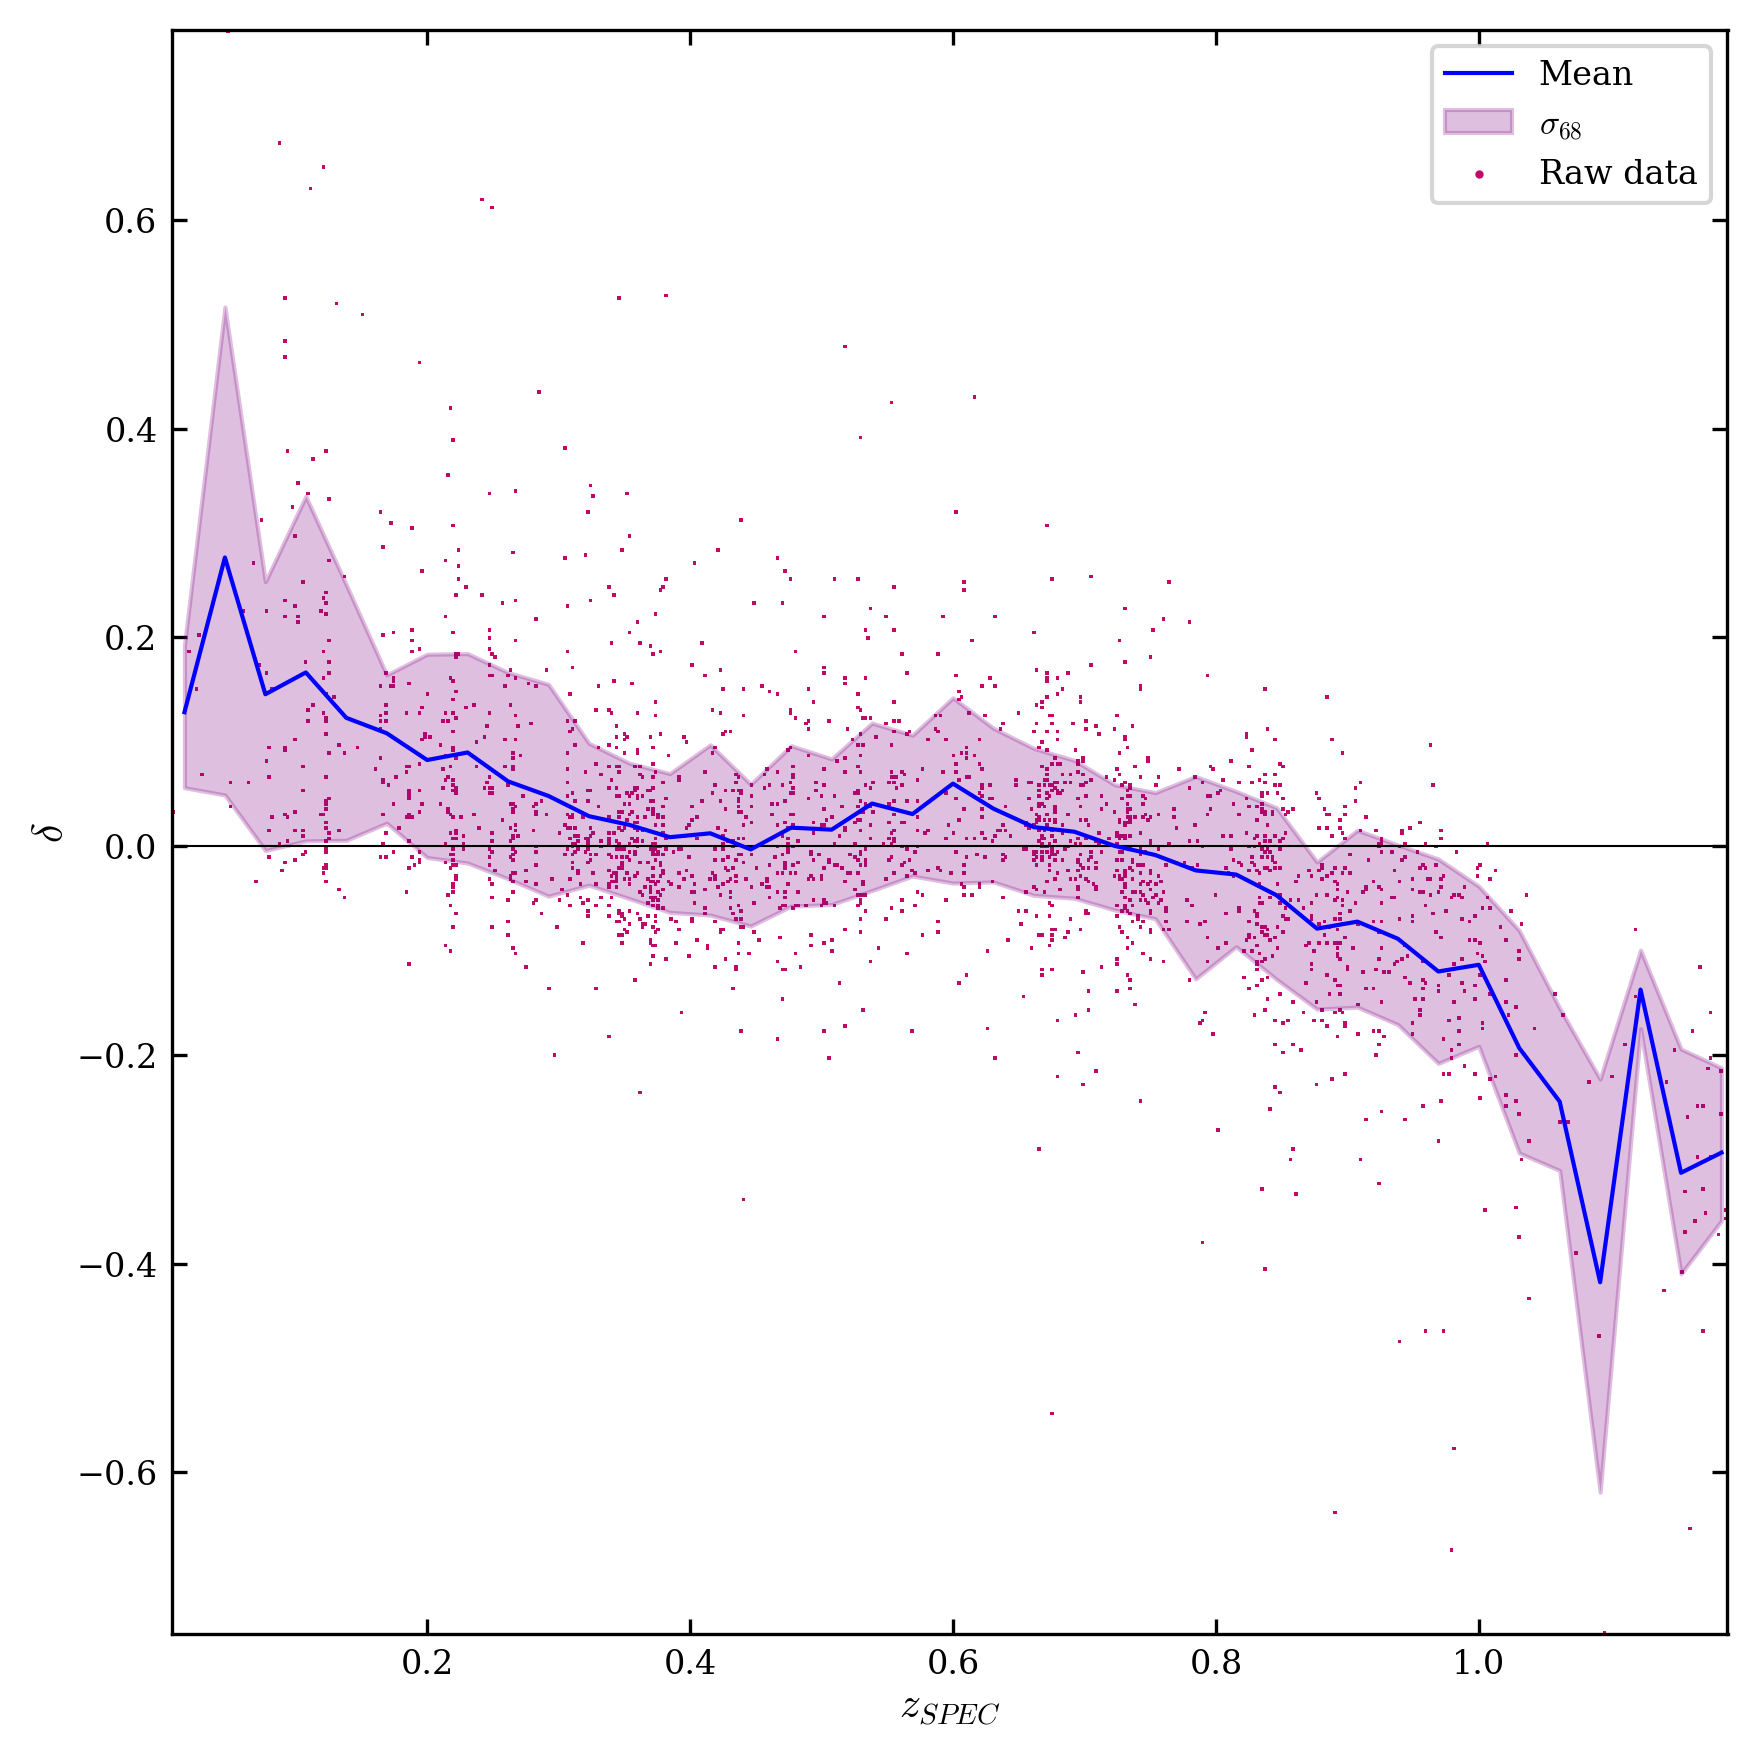

In [48]:
bins = np.linspace(0.0,1.2,40)
mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)




factor = latex_textwidth/72*0.5
plt.figure(figsize=(6,6),dpi=300)
# plt.scatter(z_paus.loc[indices],normed_error.loc[indices],s=0.1)
pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# hist = plt.hist2d(z_paus.loc[:],normed_error.loc[:],[pixs,pixs],cmap='ClearPurple',zorder=2)
plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()
plt.plot((bins[1:]+bins[:-1])/2,mean,'b-',zorder=10,label='Mean')
plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{SPEC}$')

plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
# plt.xlim(0.1,0.7)
# plt.ylim(-0.5,0.9)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
# custom_SAVEFIG('ML_ERROR')
plt.show()

# MLM run comparison

In [14]:
MLM_data_list = []

for i in range(6,11):
    MLM_data_list.append(pd.read_csv('../../ML runs/SPEC_advanced{}/ANNZ_randomReg_0000.csv'.format(i),header=0))


In [15]:
# MLM_data_list

In [22]:
def compute_error_stats(DFrame):
    z_annz = DFrame['F:ANNZ_best']
    z_paus = DFrame['F:zspec']
    z_annz_errors = DFrame['F:ANNZ_best_err']

    error = z_annz - z_paus
    normed_error = error / (1+z_paus)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_annz.values,z_annz_errors.values,z_paus.values]

In [27]:
stats = []
errors_obj = []
i = 6
for frame in MLM_data_list:
    tmp_stats = compute_error_stats(frame)
    stats.append(tmp_stats[0])
    errors_obj.append(np.array(tmp_stats[1]))
    i += 1

In [20]:
results = pd.DataFrame(stats,index=range(20,110,20),columns=["mean error","st. dev","68th percentile","percentage outliers"])
results

,mean error,st. dev,68th percentile,percentage outliers
20,0.007206,0.077259,0.049829,5.152330
40,0.007790,0.078110,0.051472,5.465950
60,0.007427,0.076933,0.050683,4.928315
80,0.007730,0.077306,0.050734,5.421147
100,0.004688,0.065788,0.039840,3.360215


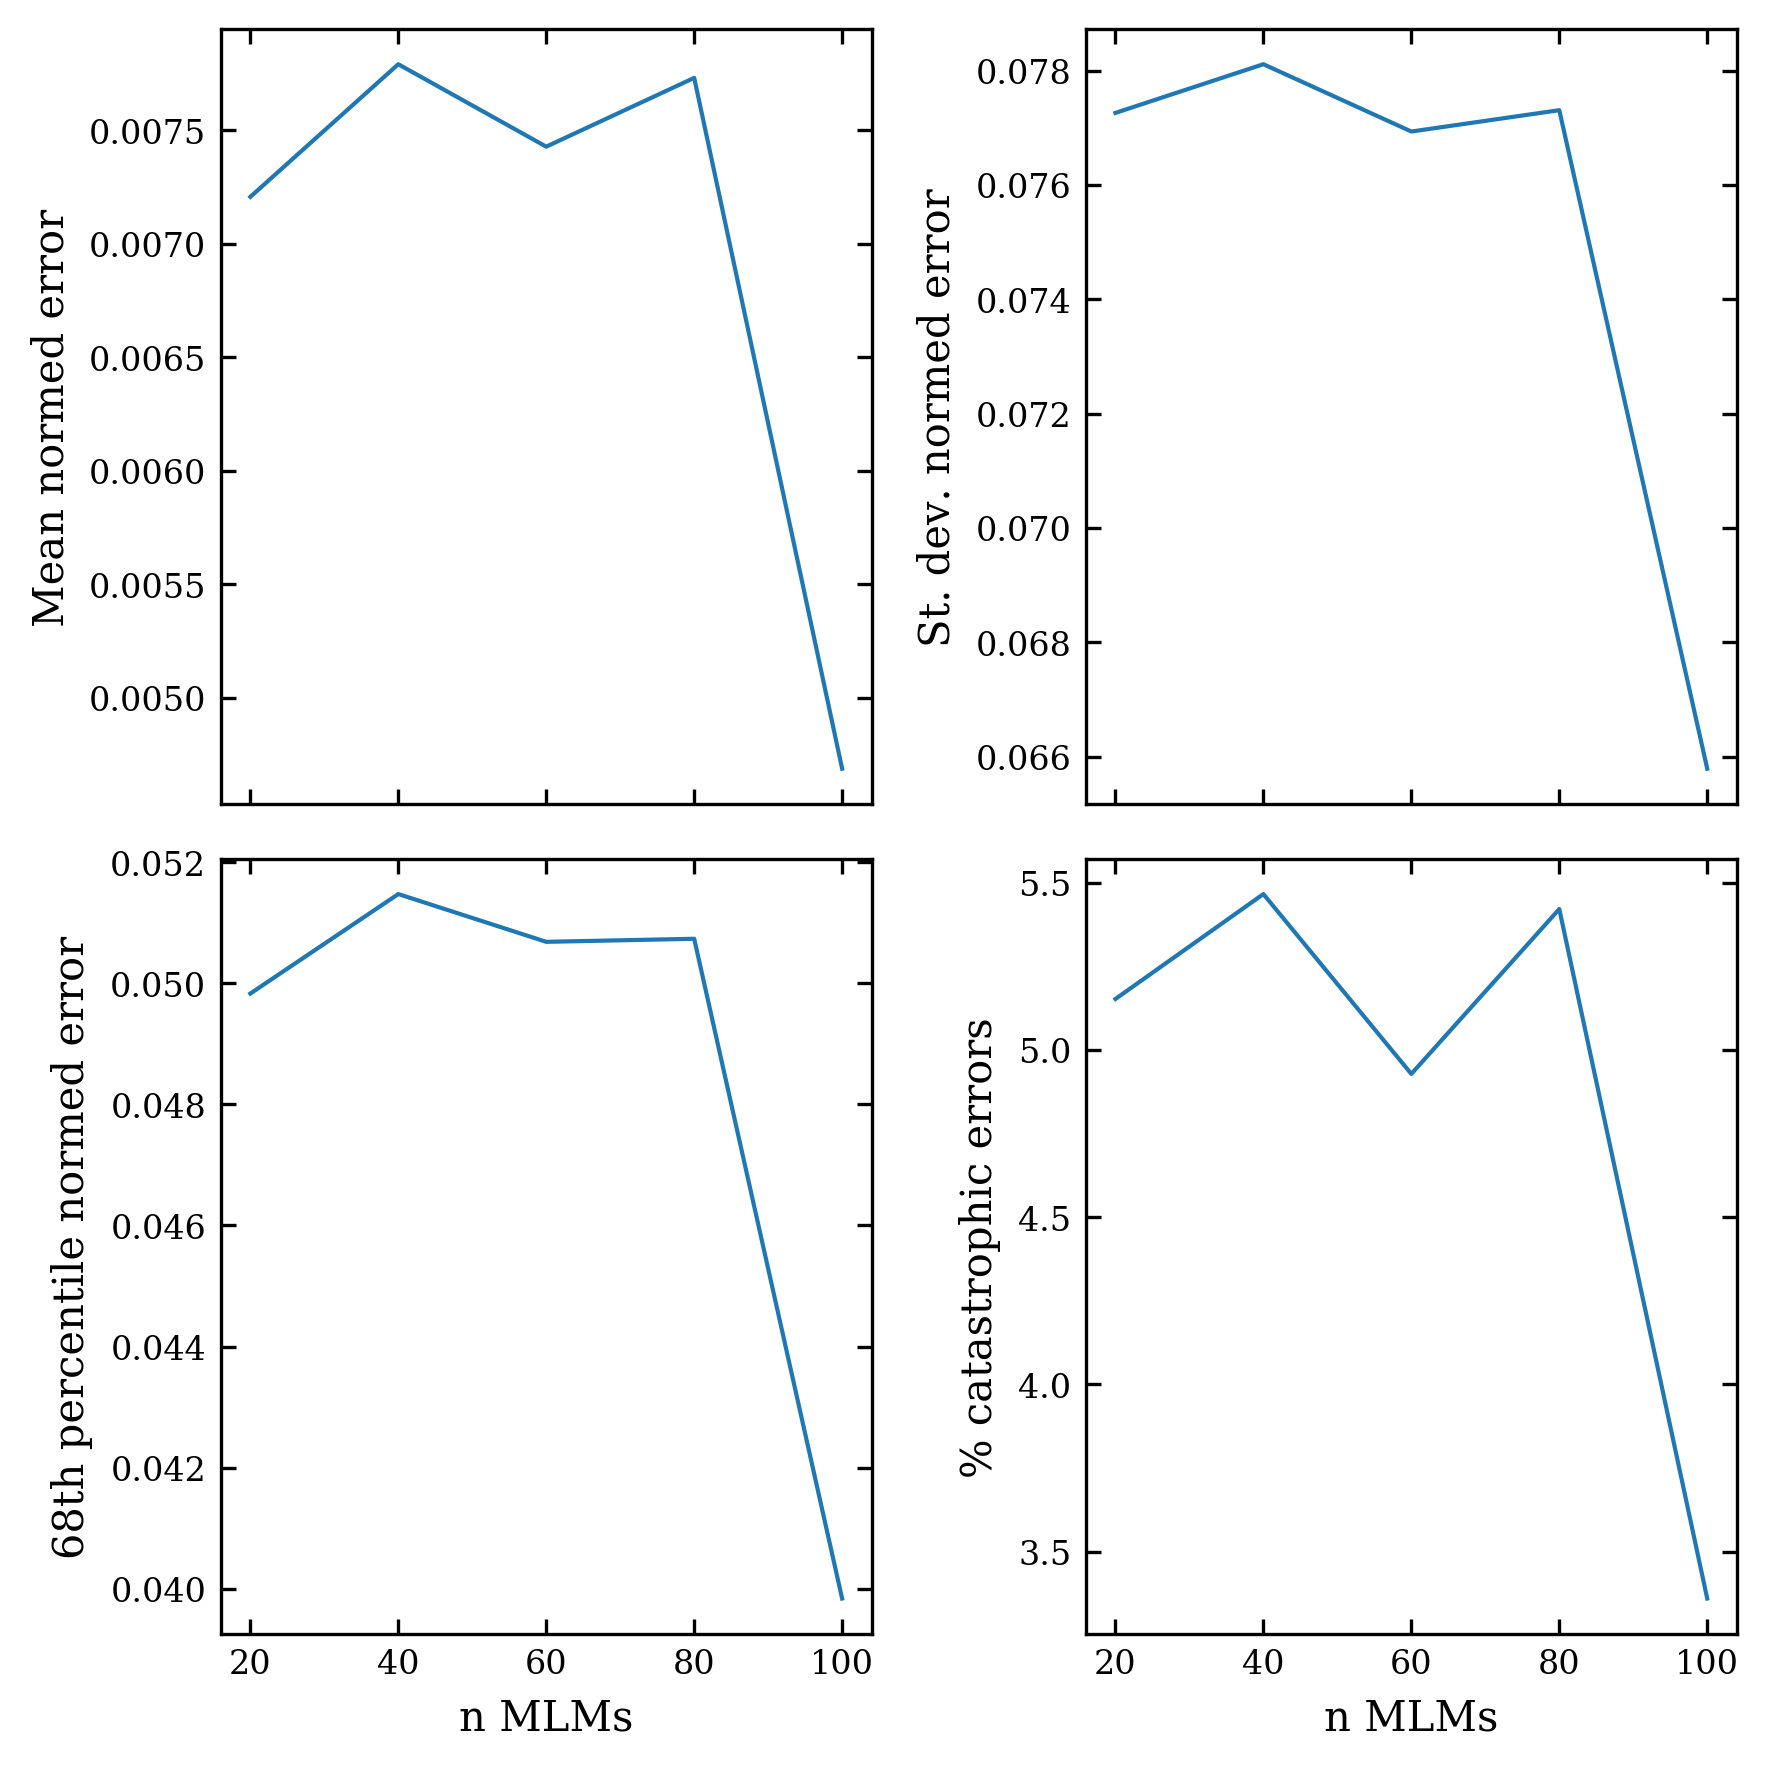

In [42]:
# plt.figure()
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,figsize=(6,6),dpi=300)

ax1.plot(results.index.values,results.iloc[:,0])
ax1.set_ylabel("Mean normed error")

ax2.plot(results.index.values,results.iloc[:,1])
ax2.set_ylabel("St. dev. normed error")

ax3.plot(results.index.values,results.iloc[:,2])
ax3.set_xlabel("n MLMs")
ax3.set_ylabel("68th percentile normed error")

ax4.plot(results.index.values,results.iloc[:,3])
ax4.set_xlabel("n MLMs")
ax4.set_ylabel("% catastrophic errors")

plt.tight_layout()

plt.show()

In [34]:
errors_all_MLMs = np.array(errors_obj)

In [36]:
errors_all_MLMs[0]

array([[0.85868275, 0.15316476, 0.65255833, ..., 0.58945489, 0.41123164,
        0.49120331],
       [0.0456476 , 0.02989124, 0.0537809 , ..., 0.03612245, 0.0526113 ,
        0.0333868 ],
       [0.87239999, 0.1867    , 0.53839999, ..., 0.44569999, 0.31029999,
        0.41859999]])

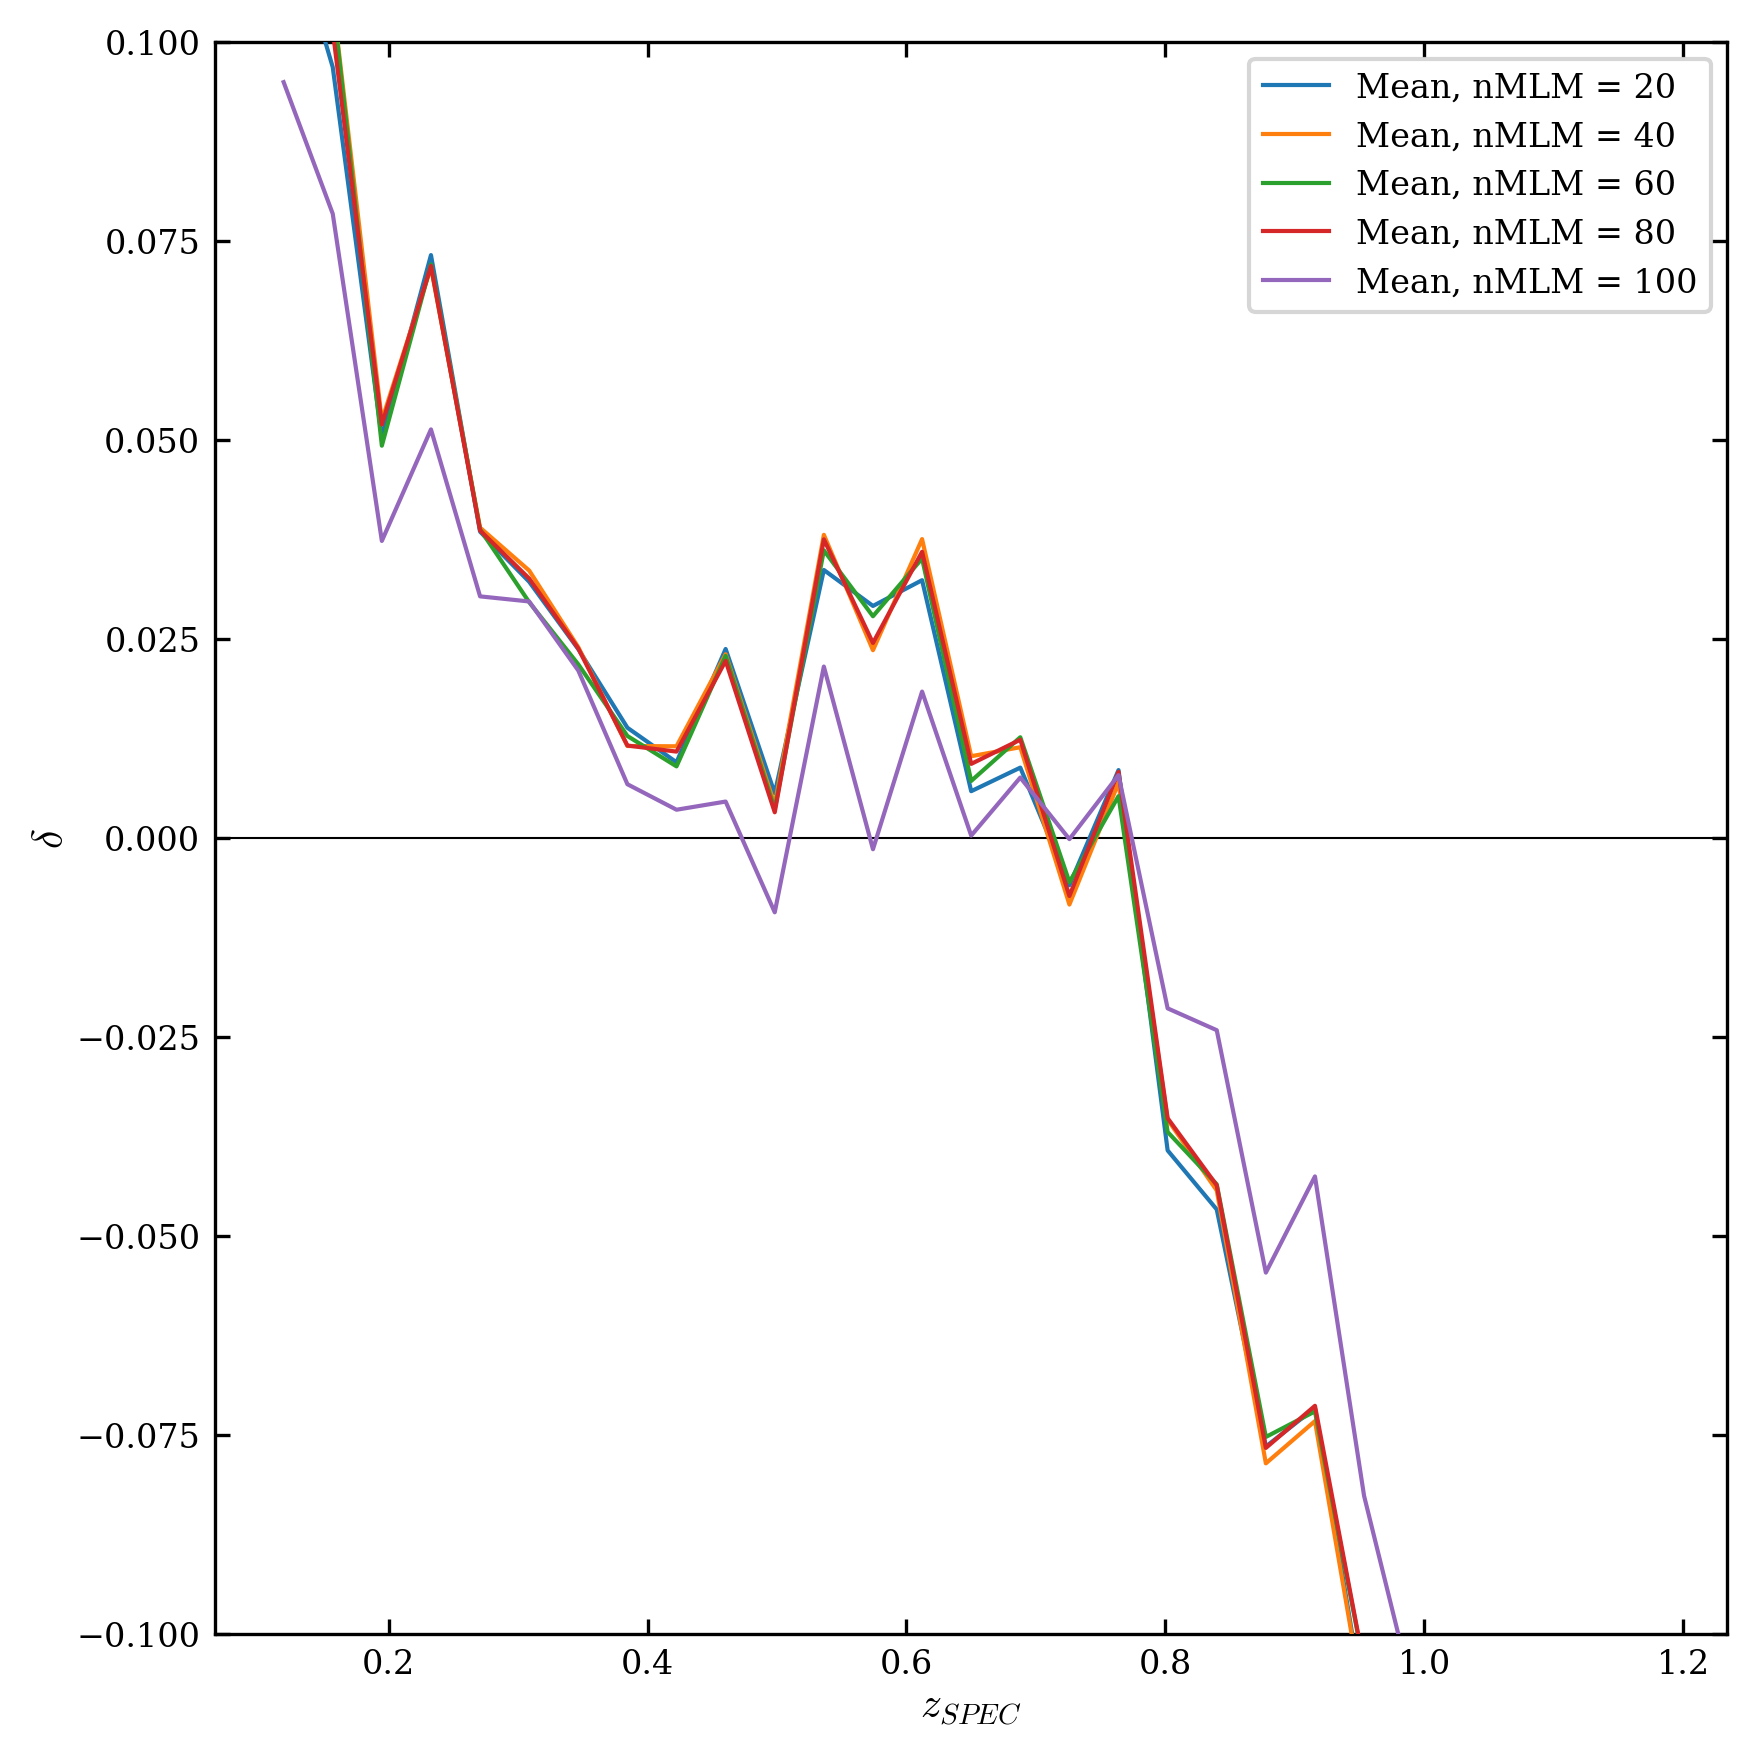

In [41]:


bins = np.linspace(0.1,1.2,30)

binned_means = []


for i in range(errors_all_MLMs.shape[0]): binned_means.append(scipy.stats.binned_statistic(errors_all_MLMs[i,2,:],errors_all_MLMs[i,0,:]-errors_all_MLMs[i,2,:],'mean',bins=bins)[0])

# lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
# ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(6,6),dpi=300)

# pixs = 600
# bounds = [0,0.9,1e6]
# norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
# hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()

for i in range(errors_all_MLMs.shape[0]): plt.plot((bins[1:]+bins[:-1])/2,binned_means[i],zorder=10,label='Mean, nMLM = {}'.format(20+i*20))


plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{SPEC}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
# plt.xlim(0.1,0.7)
plt.ylim(-.1,0.1)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
# custom_SAVEFIG('ML_ERROR')
plt.show()
